In [1]:
import tensorflow
print(tensorflow.__version__)

2.1.0


In [2]:
!pip install livelossplot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import PIL
from IPython.display import Image, display
from keras.applications.vgg16 import VGG16,preprocess_input
# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go
import plotly.graph_objects as go
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model,load_model
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.layers import GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


Let's use the jpeg files for training and testing.

In [4]:
train_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

In [5]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


### Under sampling
As we have already seen in the EDA notebook, our training data is heavily biased with benign cases. So we are going to undersample our training set by picking random 2000 record from the benign cases,and all records from the malignant cases.

In [6]:
## Original train data
train['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [7]:
## Undersampled train data
df_0=train[train['target']==0].sample(2000)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()
train['target'].value_counts()

0    2000
1     584
Name: target, dtype: int64

## Preparing the Datasets

In [8]:
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

In [9]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

### Creating a hold-out Validation Set

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.2, random_state=1234)

train=pd.DataFrame(X_train)
train.columns=['images']
train['target']=y_train

validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

### Preprocessing Images

* normalizing
* reshaping all images to size 224 x 224
* augmentation using the Keras library function ImageDataGenerator (only for train data)

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True)

val_datagen=ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    batch_size=8,
    shuffle=True,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(224, 224),
    shuffle=False,
    batch_size=8,
    class_mode='raw')

Found 2067 validated image filenames.
Found 517 validated image filenames.


## Modeling

Using pretrained VGG-16 and adding the last dense layer.
The competition is evaluated on AUC scores, so we'll use that as a metric.

In [12]:
def vgg16_model( num_classes=None):

    model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x=Flatten()(model.output)
    output=Dense(1,activation='sigmoid')(x) # because we have to predict the AUC
    model=Model(model.input,output)
    
    return model

vgg_conv=vgg16_model(1)

58892288/58889256 [==============================] - 2s 0us/step


Because of class imbalance it's better to use **focal loss** rather than normal **binary_crossentropy**.
[Source](https://arxiv.org/abs/1708.02002)

In [13]:
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

In [14]:
opt = Adam(lr=1e-5)
vgg_conv.compile(loss=focal_loss(), metrics=[tf.keras.metrics.AUC()],optimizer=opt)

In [15]:
nb_epochs = 2
batch_size=8
nb_train_steps = train.shape[0]//batch_size
nb_val_steps=validation.shape[0]//batch_size
print("Number of training and validation steps: {} and {}".format(nb_train_steps,nb_val_steps))

Number of training and validation steps: 258 and 64


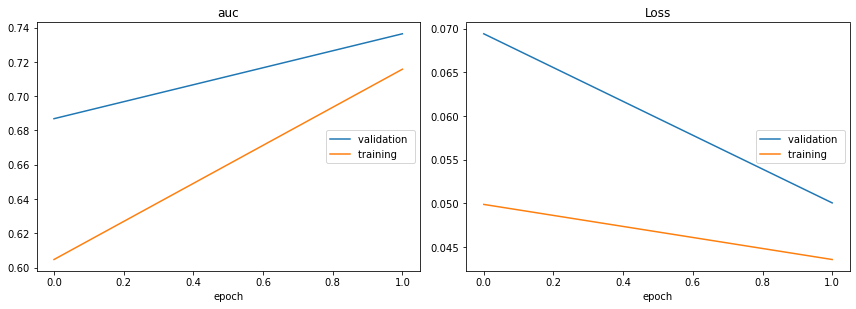

auc
	validation       	 (min:    0.687, max:    0.736, cur:    0.736)
	training         	 (min:    0.605, max:    0.716, cur:    0.716)
Loss
	validation       	 (min:    0.050, max:    0.069, cur:    0.050)
	training         	 (min:    0.044, max:    0.050, cur:    0.044)


In [16]:
cb = [PlotLossesKeras()]
vgg_conv.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_steps,
    epochs=nb_epochs,
    validation_data=validation_generator,
    callbacks=cb,
    validation_steps=nb_val_steps)

## Submission

In [17]:
target=[]
for path in df_test['images']:
    img=cv2.imread(str(path))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    img=np.reshape(img,(1,224,224,3))
    prediction=vgg_conv.predict(img)
    target.append(prediction[0][0])

submission['target']=target

In [18]:
submission.to_csv('submission.csv', index=False)
submission.head()

,image_name,target
0,ISIC_0052060,0.223755
1,ISIC_0052349,0.183337
2,ISIC_0058510,0.157335
3,ISIC_0073313,0.136887
4,ISIC_0073502,0.284987
